In [1]:
"""
Demo contracts and components for testing FuzzyPipeline capabilities.
"""
import pandas as pd
import numpy as np

from axisfuzzy.analysis.build_in import (
    ContractCrispTable, ContractWeightVector,
)

from axisfuzzy.analysis.component.basic import (
    ToolNormalization, ToolWeightNormalization
)
from axisfuzzy.analysis.pipeline import FuzzyPipeline

from example_basic_dependency_file import (ContractAccuracyVector,
                                            ContractOrderResult,
                                            ContractMultiMetrics,
                                            DemoDataGenerator,
                                            DemoScoreCalculator,
                                            DemoMultiOutputAnalyzer,
                                            DemoRanker,
                                            DemoDataAggregator)

In [2]:
def demo_single_input_single_output():
    """
    Demo: Single Input -> Single Output

    Pipeline: raw_data -> normalization -> normalized_data
    """
    print("=" * 60)
    print("Demo 1: Single Input -> Single Output")
    print("=" * 60)

    # Create components
    normalizer = ToolNormalization(method='min_max', axis=0)

    # Build pipeline
    pipeline = FuzzyPipeline(name="SingleInput_SingleOutput_Pipeline")

    # Define single input
    raw_data = pipeline.input("raw_data", contract=ContractCrispTable)

    # Process data
    normalized_data = pipeline.add(normalizer.run, data=raw_data)

    # Test data
    test_data = pd.DataFrame({
        'A': [1, 2, 3, 4, 5],
        'B': [10, 20, 30, 40, 50],
        'C': [100, 200, 300, 400, 500]
    })

    # Run pipeline
    result = pipeline.run({"raw_data": test_data})

    print(f"Input shape: {test_data.shape}")
    print(f"Output shape: {result.shape}")
    print(f"Output type: {type(result)}")
    print("\nOutput preview:")
    print(result.head())

    return pipeline, result

In [3]:
def demo_single_input_multi_output():
    """
    Demo: Single Input -> Multiple Outputs

    Pipeline: raw_data -> multi_analyzer -> {row_stats, col_stats}
    """
    print("\n" + "=" * 60)
    print("Demo 2: Single Input -> Multiple Outputs")
    print("=" * 60)

    # Create components
    multi_analyzer = DemoMultiOutputAnalyzer()

    # Build pipeline
    pipeline = FuzzyPipeline(name="SingleInput_MultiOutput_Pipeline")

    # Define single input
    raw_data = pipeline.input("raw_data", contract=ContractCrispTable)

    # Multi-output processing
    analysis_results = pipeline.add(multi_analyzer.run, data=raw_data)

    # Test data
    test_data = pd.DataFrame(np.random.rand(5, 3) * 100, columns=['X', 'Y', 'Z'])

    # Run pipeline
    result = pipeline.run({"raw_data": test_data})

    print(f"Input shape: {test_data.shape}")
    print(f"Output type: {type(result)}")
    print(f"Output keys: {list(result.keys()) if isinstance(result, dict) else 'Single output'}")
    print("\nOutput preview:")
    if isinstance(result, dict):
        for key, value in result.items():
            print(f"{key}: {value}")
    else:
        print(result)

    return pipeline, result

In [4]:
def demo_multi_input_single_output():
    """
    Demo: Multiple Inputs -> Single Output

    Pipeline: {raw_data, weights} -> score_calculator -> scores
    """
    print("\n" + "=" * 60)
    print("Demo 3: Multiple Inputs -> Single Output")
    print("=" * 60)

    # Create components
    normalizer = ToolNormalization(method='min_max', axis=0)
    weight_normalizer = ToolWeightNormalization()
    score_calculator = DemoScoreCalculator()

    # Build pipeline
    pipeline = FuzzyPipeline(name="MultiInput_SingleOutput_Pipeline")

    # Define multiple inputs
    raw_data = pipeline.input("raw_data", contract=ContractCrispTable)
    raw_weights = pipeline.input("raw_weights", contract=ContractWeightVector)

    # Process inputs
    normalized_data = pipeline.add(normalizer.run, data=raw_data)
    normalized_weights = pipeline.add(weight_normalizer.run, weights=raw_weights)

    # Combine inputs for single output
    final_scores = pipeline.add(
        score_calculator.run,
        data=normalized_data,
        weights=normalized_weights
    )

    # Test data
    test_data = pd.DataFrame({
        'Criterion1': [0.8, 0.6, 0.9, 0.7],
        'Criterion2': [0.7, 0.8, 0.6, 0.9],
        'Criterion3': [0.9, 0.7, 0.8, 0.6]
    })
    test_weights = np.array([0.4, 0.3, 0.3])

    # Run pipeline
    result = pipeline.run({
        "raw_data": test_data,
        "raw_weights": test_weights
    })

    print(f"Input data shape: {test_data.shape}")
    print(f"Input weights shape: {test_weights.shape}")
    print(f"Output type: {type(result)}")
    print(f"Output shape: {result.shape}")
    print("\nFinal Scores:")
    print(result)

    return pipeline, result

In [5]:
def demo_multi_input_multi_output():
    """
    Demo: Multiple Inputs -> Multiple Outputs

    Pipeline: {data1, data2, weights} -> aggregator -> aggregated_data
                                    -> analyzer -> {row_stats, col_stats}
                                    -> ranker -> rankings
    """
    print("\n" + "=" * 60)
    print("Demo 4: Multiple Inputs -> Multiple Outputs")
    print("=" * 60)

    # Create components
    aggregator = DemoDataAggregator(aggregation_method='weighted_average')
    multi_analyzer = DemoMultiOutputAnalyzer()
    normalizer = ToolNormalization(method='min_max', axis=0)
    score_calculator = DemoScoreCalculator()
    ranker = DemoRanker(ascending=False)
    weight_normalizer = ToolWeightNormalization()

    # Build pipeline
    pipeline = FuzzyPipeline(name="MultiInput_MultiOutput_Pipeline")

    # Define multiple inputs
    data1 = pipeline.input("data1", contract=ContractCrispTable)
    data2 = pipeline.input("data2", contract=ContractCrispTable)
    agg_weights = pipeline.input("agg_weights", contract=ContractWeightVector)
    score_weights = pipeline.input("score_weights", contract=ContractWeightVector)

    # Process and aggregate data
    normalized_agg_weights = pipeline.add(weight_normalizer.run, weights=agg_weights)
    aggregated_data = pipeline.add(
        aggregator.run,
        data1=data1,
        data2=data2,
        weights=normalized_agg_weights
    )

    # Multiple analysis paths for multiple outputs
    # Path 1: Statistical analysis
    stats_results = pipeline.add(multi_analyzer.run, data=aggregated_data)

    # Path 2: Scoring and ranking
    normalized_data = pipeline.add(normalizer.run, data=aggregated_data)
    normalized_score_weights = pipeline.add(weight_normalizer.run, weights=score_weights)
    scores = pipeline.add(
        score_calculator.run,
        data=normalized_data,
        weights=normalized_score_weights
    )
    rankings = pipeline.add(ranker.run, scores=scores)

    # Test data
    test_data1 = pd.DataFrame({
        'A': [1, 2, 3, 4],
        'B': [10, 20, 30, 40],
        'C': [100, 200, 300, 400]
    })
    test_data2 = pd.DataFrame({
        'A': [2, 3, 4, 5],
        'B': [15, 25, 35, 45],
        'C': [150, 250, 350, 450]
    })
    test_agg_weights = np.array([0.6, 0.4])
    test_score_weights = np.array([0.5, 0.3, 0.2])

    # Run pipeline
    result = pipeline.run({
        "data1": test_data1,
        "data2": test_data2,
        "agg_weights": test_agg_weights,
        "score_weights": test_score_weights
    })

    print(f"Input data1 shape: {test_data1.shape}")
    print(f"Input data2 shape: {test_data2.shape}")
    print(f"Output type: {type(result)}")
    print(f"Output components: {list(result.keys()) if isinstance(result, dict) else 'Single output'}")
    print("\nMultiple Outputs:")
    if isinstance(result, dict):
        for key, value in result.items():
            print(f"\n{key}:")
            print(f"  Type: {type(value)}")
            if hasattr(value, 'shape'):
                print(f"  Shape: {value.shape}")
            print(f"  Value: {value}")

    return pipeline, result

In [6]:
def demo_step_by_step_execution():
    """
    Demo: Step-by-step execution using FuzzyPipelineIterator
    """
    print("\n" + "=" * 60)
    print("Demo 5: Step-by-Step Execution")
    print("=" * 60)

    # Reuse the multi-input single-output pipeline
    normalizer = ToolNormalization(method='min_max', axis=0)
    weight_normalizer = ToolWeightNormalization()
    score_calculator = DemoScoreCalculator()

    pipeline = FuzzyPipeline(name="StepByStep_Pipeline")

    raw_data = pipeline.input("raw_data", contract=ContractCrispTable)
    raw_weights = pipeline.input("raw_weights", contract=ContractWeightVector)

    normalized_data = pipeline.add(normalizer.run, data=raw_data)
    normalized_weights = pipeline.add(weight_normalizer.run, weights=raw_weights)
    final_scores = pipeline.add(
        score_calculator.run,
        data=normalized_data,
        weights=normalized_weights
    )

    # Test data
    test_data = pd.DataFrame({
        'Quality': [0.8, 0.6, 0.9, 0.7],
        'Price': [0.7, 0.8, 0.6, 0.9],
        'Service': [0.9, 0.7, 0.8, 0.6]
    })
    test_weights = np.array([0.5, 0.3, 0.2])

    # Step-by-step execution
    print("Executing pipeline step by step...")
    for step in pipeline.step_by_step({
        "raw_data": test_data,
        "raw_weights": test_weights
    }):
        print(f"\nStep {step['step_index'] + 1}/{step['total_steps']}: {step['step_name']}")
        print(f"Execution time: {step['execution_time']:.4f}s")
        print(f"Result type: {type(step['result'])}")
        if hasattr(step['result'], 'shape'):
            print(f"Result shape: {step['result'].shape}")

    return pipeline

In [7]:
# Demo 1: Single Input -> Single Output
pipeline1, result1 = demo_single_input_single_output()
# Demo 2: Single Input -> Multiple Outputs
pipeline2, result2 = demo_single_input_multi_output()
# Demo 3: Multiple Inputs -> Single Output
pipeline3, result3 = demo_multi_input_single_output()
# Demo 4: Multiple Inputs -> Multiple Outputs
pipeline4, result4 = demo_multi_input_multi_output()
# Demo 5: Step-by-Step Execution
pipeline5 = demo_step_by_step_execution()

Demo 1: Single Input -> Single Output
Input shape: (5, 3)
Output shape: (5, 3)
Output type: <class 'pandas.core.frame.DataFrame'>

Output preview:
      A     B     C
0  0.00  0.00  0.00
1  0.25  0.25  0.25
2  0.50  0.50  0.50
3  0.75  0.75  0.75
4  1.00  1.00  1.00

Demo 2: Single Input -> Multiple Outputs
Input shape: (5, 3)
Output type: <class 'dict'>
Output keys: ['row_statistics', 'column_statistics']

Output preview:
row_statistics: {'mean': 50.89597317570839, 'std': 18.684188387256278, 'min': 22.27563449406249, 'max': 68.2869081372215}
column_statistics: {'mean': 50.895973175708384, 'std': 13.773011968403184, 'min': 36.511236493169434, 'max': 63.96246882342016}

Demo 3: Multiple Inputs -> Single Output
Input data shape: (4, 3)
Input weights shape: (3,)
Output type: <class 'pandas.core.series.Series'>
Output shape: (4,)

Final Scores:
0    0.666667
1    0.300000
2    0.600000
3    0.433333
Name: composite_score, dtype: float64

Demo 4: Multiple Inputs -> Multiple Outputs
Input da

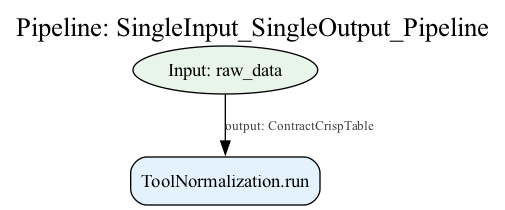

In [8]:
pipeline1.visualize()

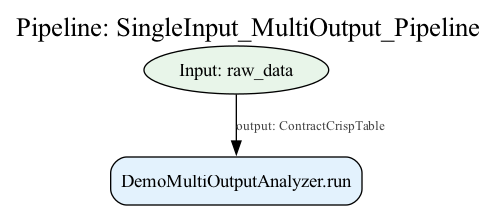

In [9]:
pipeline2.visualize()

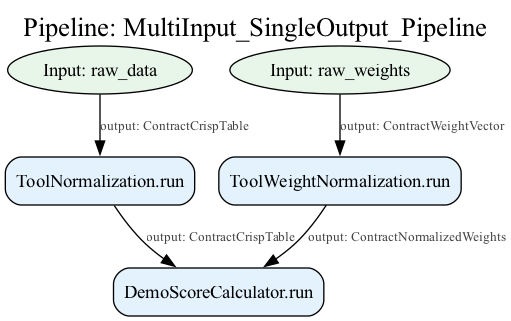

In [10]:
pipeline3.visualize()

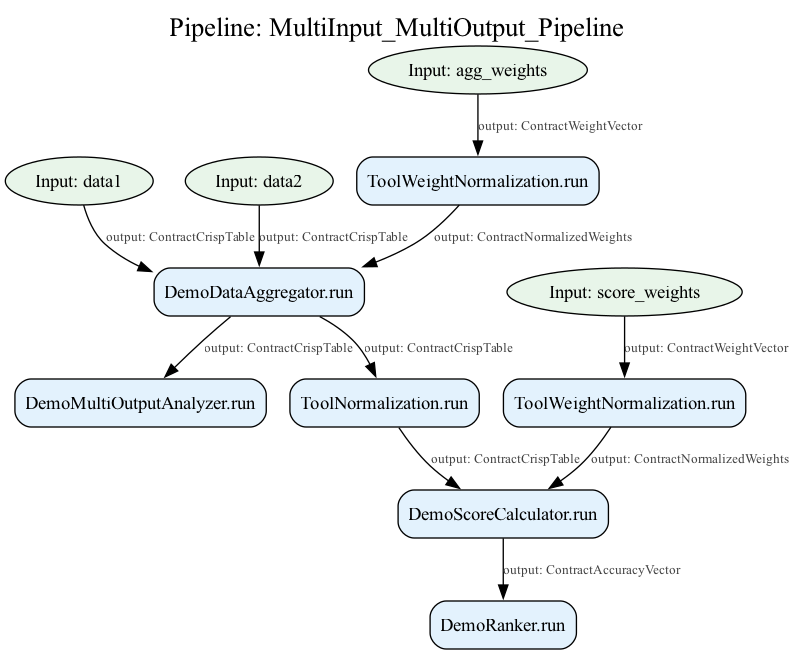

In [11]:
pipeline4.visualize()

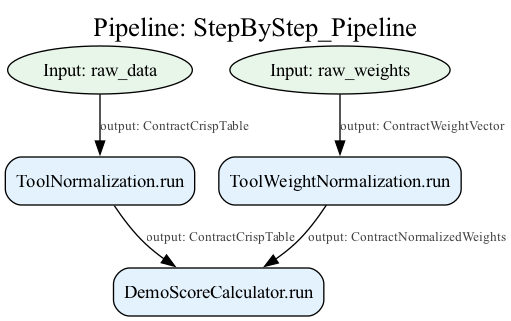

In [12]:
pipeline5.visualize()